<a href="https://colab.research.google.com/github/leokato3939/TestRemoteRepository/blob/main/07_linear_regression_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ケーススタディ: solubility data

* 下記の書籍のSection 6.1で紹介されているデータセットを使ってみる。
  * Max Kuhn and Kjell Johnson. Applied Predictive Modeling. Springer, 2013.
  * http://appliedpredictivemodeling.com/data

* 説明変数は下記の228個
  * **Two hundred and eight** binary “fingerprints” that indicate the presence or absence of a particular chemical substructure.
  * **Sixteen** count descriptors, such as the number of bonds or the number of bromine atoms.
  * **Four** continuous descriptors, such as molecular weight or surface area.

* 目的変数はlog solubility
  * 範囲は-11.6から1.6、平均は-2.7

## データを読み込む

In [ ]:
import os
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

%config InlineBackend.figure_format = 'retina'

In [22]:
data_path = '/content/'

# 訓練データ
X = pd.read_csv(os.path.join(data_path, 'solTrainX.csv'))
y = pd.read_csv(os.path.join(data_path, 'solTrainY.csv'))['x']

# テストデータ
X_test = pd.read_csv(os.path.join(data_path, 'solTestX.csv'))
y_test = pd.read_csv(os.path.join(data_path, 'solTestY.csv'))['x']

In [ ]:
X.head()

In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951 entries, 0 to 950
Columns: 229 entries, Unnamed: 0 to SurfaceArea2
dtypes: float64(4), int64(225)
memory usage: 1.7 MB


In [24]:
y.head()

,x
0,-3.97
1,-3.98
2,-3.99
3,-4.00
4,-4.06


## 訓練データのEDA

### 連続値をとる特徴量

In [25]:
continuous = [s for s in X.columns if s[:3] in ['Num', 'Hyd', 'Mol', 'Sur']]
print('There are', len(continuous), 'continuous features.')
print(continuous)

There are 20 continuous features.
['MolWeight', 'NumAtoms', 'NumNonHAtoms', 'NumBonds', 'NumNonHBonds', 'NumMultBonds', 'NumRotBonds', 'NumDblBonds', 'NumAromaticBonds', 'NumHydrogen', 'NumCarbon', 'NumNitrogen', 'NumOxygen', 'NumSulfer', 'NumChlorine', 'NumHalogen', 'NumRings', 'HydrophilicFactor', 'SurfaceArea1', 'SurfaceArea2']


* 目的変数との関連を可視化する。

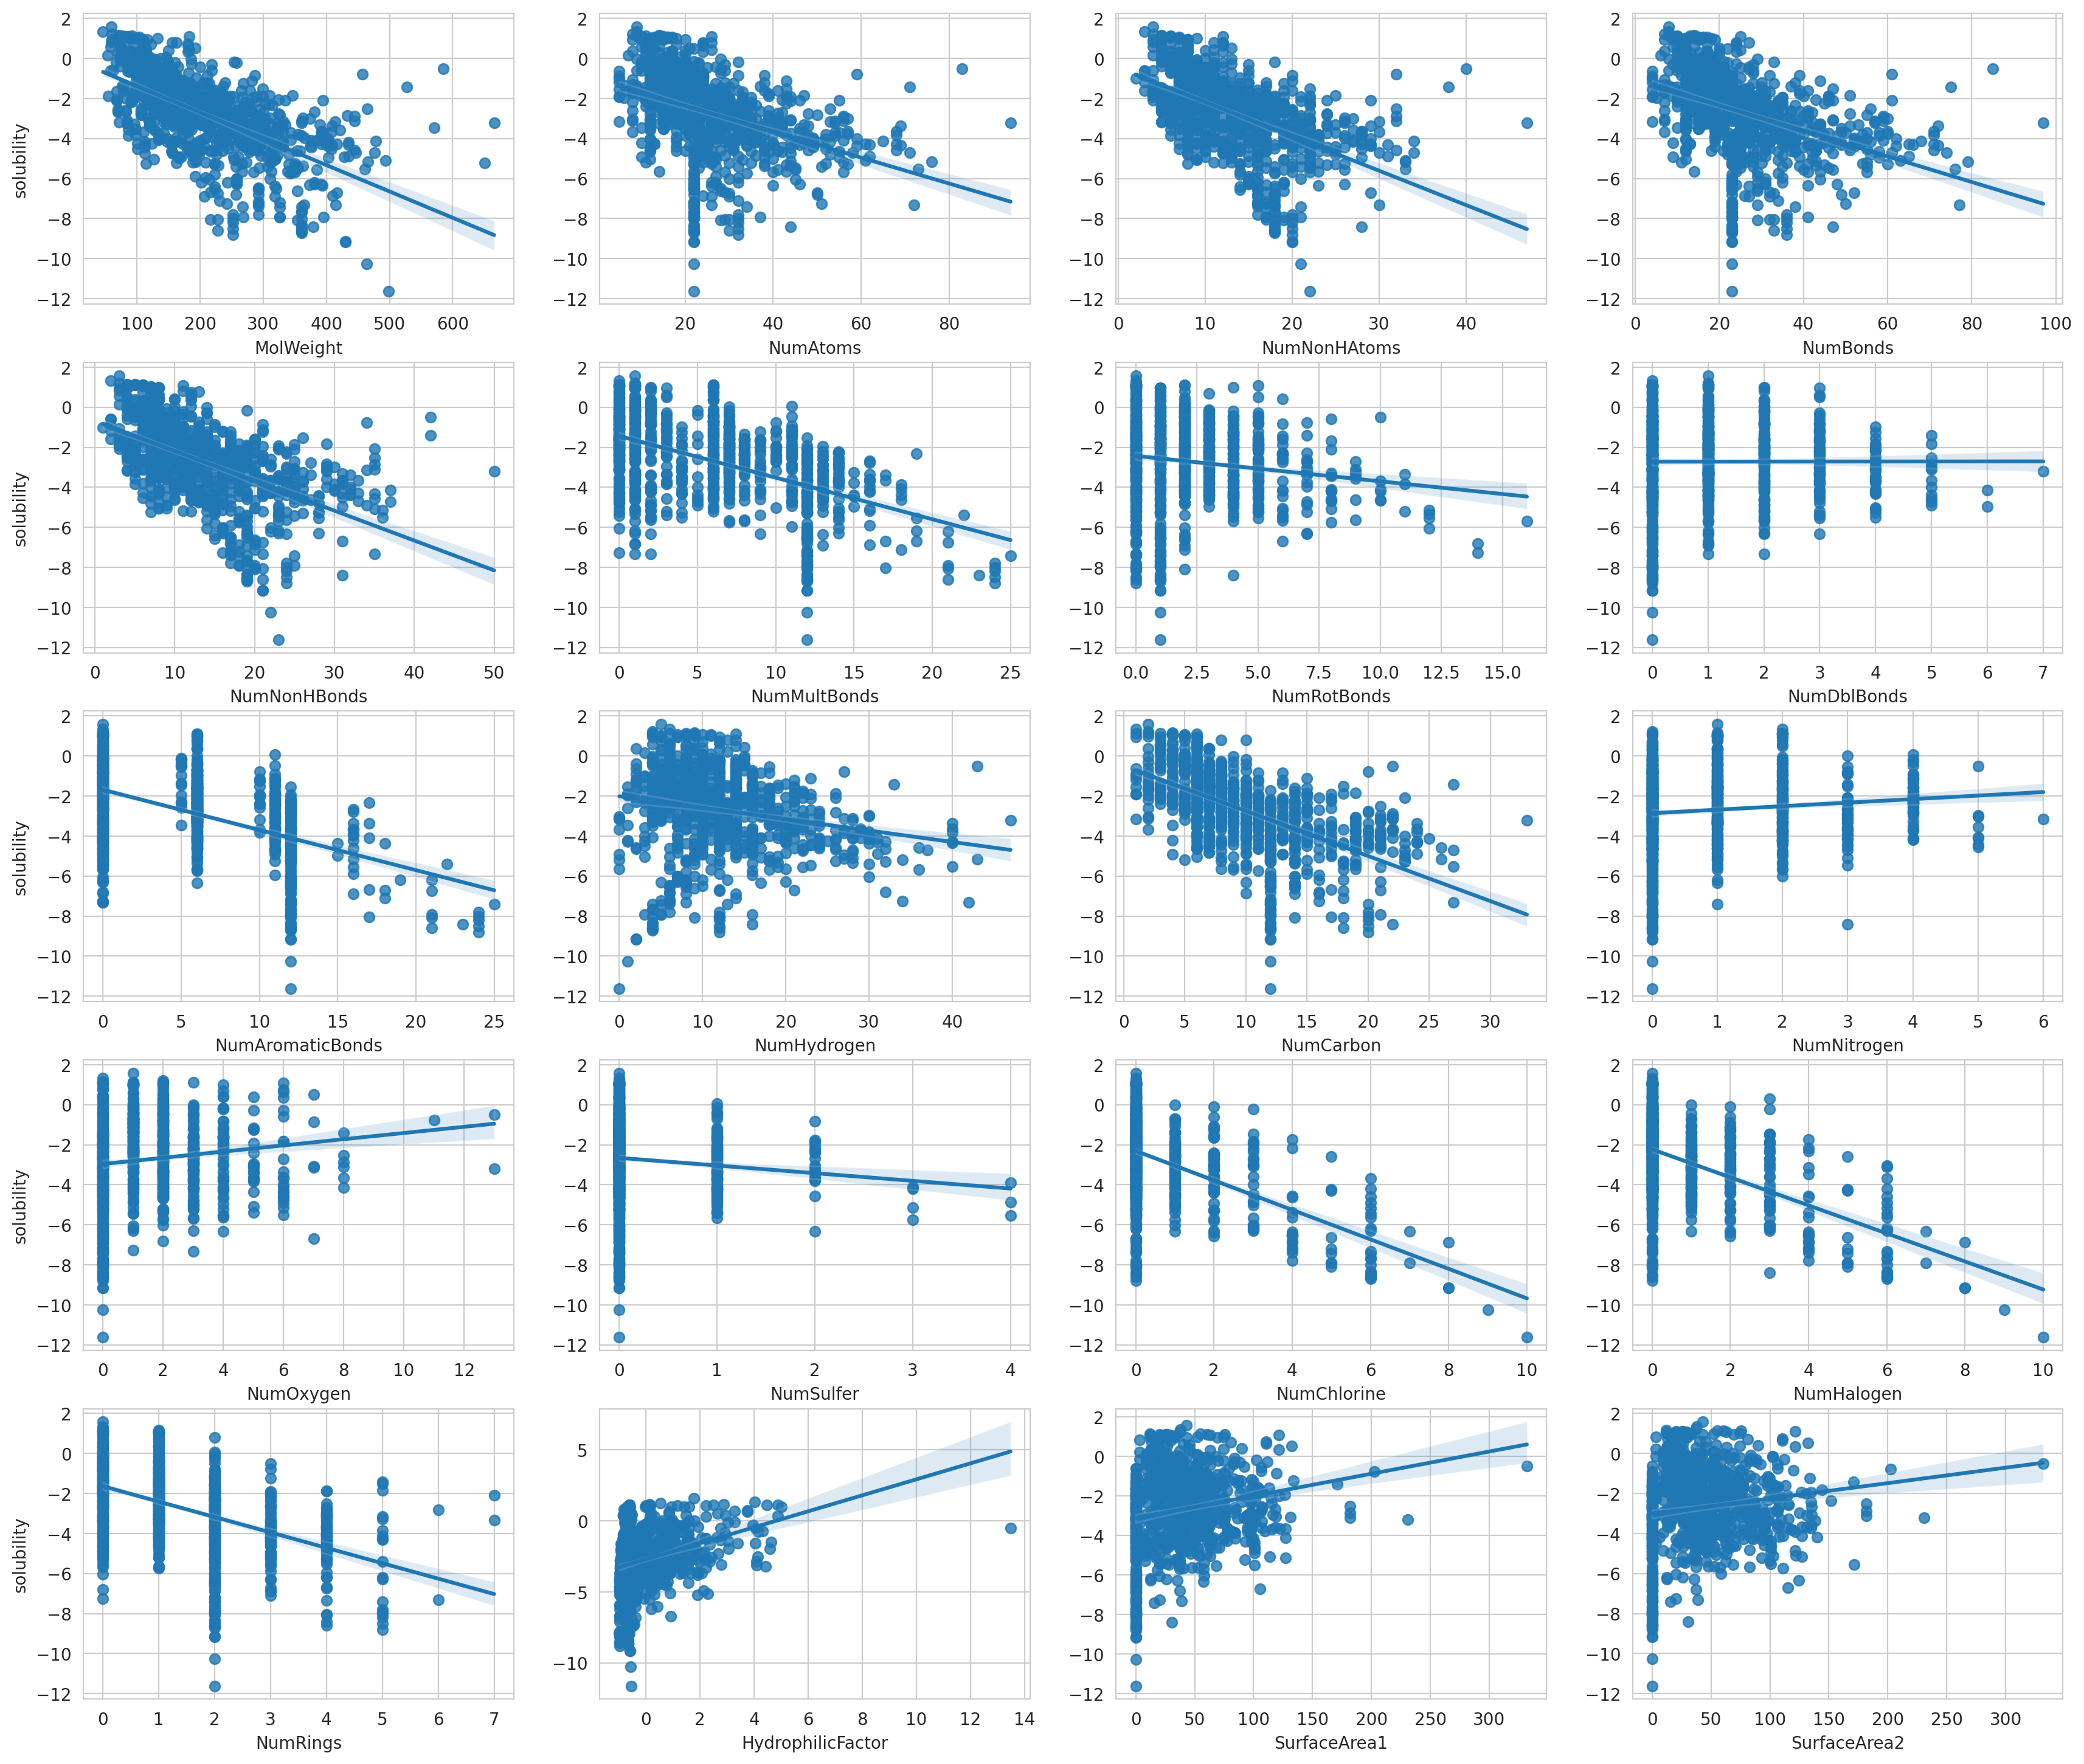

In [26]:
# 図を描くために、一時的にこうしておく
X['solubility'] = y

sns.set_style("whitegrid")
fig = plt.figure(figsize=(21, 18))
for i in range(20):
  ax = fig.add_subplot(5, 4, i+1)
  sns.regplot(x=continuous[i], y='solubility', data=X, ax=ax)
  if i % 4 != 0:
    ax.set_ylabel('')

# 図を描き終えたので、元に戻す
X = X.drop('solubility', axis=1)

### 0/1の2値をとる特徴量

In [27]:
binary = X.columns[X.columns.str.startswith('FP')]
print(len(binary), 'binary features')
X[binary].describe()

208 binary features


,FP001,FP002,FP003,FP004,FP005,FP006,FP007,FP008,FP009,FP010,...,FP199,FP200,FP201,FP202,FP203,FP204,FP205,FP206,FP207,FP208
count,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,...,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000
mean,0.493165,0.539432,0.436383,0.584648,0.579390,0.400631,0.363828,0.325973,0.279706,0.178759,...,0.047319,0.049422,0.052576,0.257624,0.114616,0.098843,0.077813,0.059937,0.056782,0.112513
std,0.500216,0.498705,0.496197,0.493042,0.493917,0.490284,0.481353,0.468984,0.449091,0.383352,...,0.212431,0.216861,0.223303,0.437556,0.318726,0.298609,0.268018,0.237495,0.231548,0.316163
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## そのまま線形回帰を適用

* 検証データを取り出しておく

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

* 線形回帰モデルのパラメータを最小二乗法で推定させる


In [29]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

* 検証データでの予測を評価する
  * 評価尺度はRMSE (root-mean-square error) とする。
  * RMSEは、小さいほど、良い。


In [30]:
y_valid_pred = reg.predict(X_valid)
print(f'RMSE: {root_mean_squared_error(y_valid, y_valid_pred):.4f}')

RMSE: 0.6338


* このRMSEを改善できるかどうか、いろいろ試行錯誤する。

## 2値の部分だけをPCAで次元圧縮

In [31]:
from sklearn.decomposition import PCA

n_components = 100 # 使用する主成分の個数
pca = PCA(n_components=n_components, random_state=123)
pca.fit(X_train[binary])

PCA(n_components=100, random_state=123)

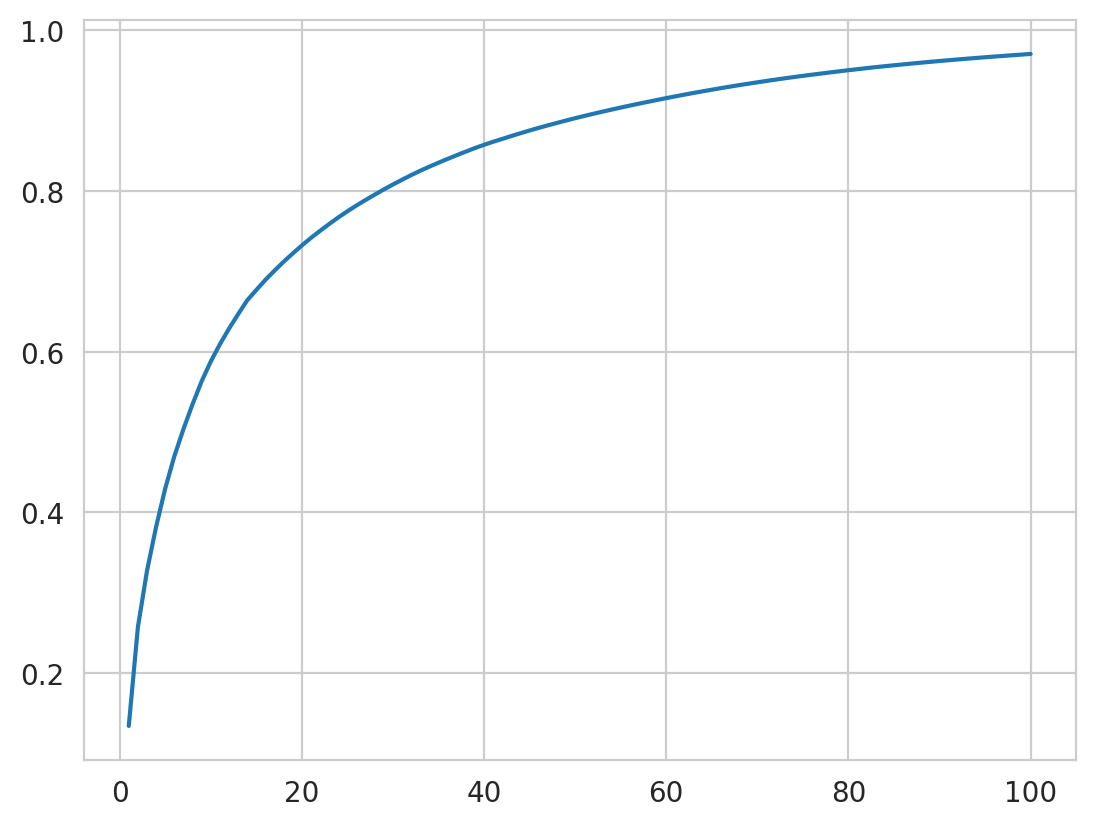

In [32]:
plt.plot(np.arange(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_));

In [33]:
pca.explained_variance_ratio_.sum()

np.float64(0.9702712867559439)

In [35]:
X_train_binary_embedded = pca.transform(X_train[binary])

In [36]:
X_train_binary_embedded.shape

(760, 100)

In [37]:
X_train_binary_embedded[0]

array([ 1.65124652e+00,  2.20555259e+00, -1.09629565e-01,  7.90365832e-01,
       -9.79572592e-01,  3.51703942e-01,  1.52232474e+00, -1.08112309e+00,
        1.94580834e-01,  5.96888262e-01,  2.24493749e-01,  1.68565912e-01,
       -9.59370426e-01, -1.44669048e+00, -5.18748091e-02,  7.53452027e-01,
        1.89751293e-01, -5.86278995e-01, -4.48451102e-02,  7.42056263e-01,
       -8.77553107e-01,  1.44020436e-01,  6.28629919e-01,  1.63014826e+00,
       -5.73014624e-01,  3.03871044e-01, -4.69353499e-01, -1.17528665e+00,
        1.03486178e+00, -2.13017119e-01, -2.20373653e-01,  2.06098939e-01,
       -2.24845634e-01,  9.54024080e-01, -1.30898066e+00,  1.67562261e-03,
       -5.73626820e-02,  2.82729539e-01,  9.65866355e-01, -7.99700270e-01,
       -2.37126348e-01,  3.86682403e-02,  6.60140168e-02,  1.32777780e-02,
        6.08357999e-01,  5.45539703e-01, -6.16492157e-01, -5.85473662e-01,
       -1.01627373e-01, -6.10258455e-02,  3.06948895e-01,  6.32681898e-01,
       -3.75106836e-01,  

* 2値変数の部分を次元削減した後のものと、元の連続値の部分とを、くっつける


In [38]:
X_train_embedded = np.concatenate([X_train_binary_embedded, X_train[continuous]], 1)

* X_train_embeddedを使って線形回帰モデルのパラメータを決める
* そして検証データでの予測スコアを求める
  * もちろん、検証データの2値の部分も、次元削減する必要があります。


In [39]:
reg = LinearRegression()
reg.fit(X_train_embedded, y_train)

X_valid_binary_embedded = pca.transform(X_valid[binary])
X_valid_embedded = np.concatenate([X_valid_binary_embedded, X_valid[continuous]], 1)
y_valid_pred = reg.predict(X_valid_embedded)
print(f'RMSE: {root_mean_squared_error(y_valid, y_valid_pred):.4f}')

RMSE: 0.6483


### 演習問題
* 以下のコードで、`n_components=0.99`の部分は、どういう意味だろうか？

In [40]:
pca = PCA(n_components=0.99, random_state=123)
X_train_binary_embedded = pca.fit_transform(X_train[binary])

X_train_embedded = np.concatenate([X_train_binary_embedded, X_train[continuous]], 1)

reg = LinearRegression()
reg.fit(X_train_embedded, y_train)

X_valid_binary_embedded = pca.transform(X_valid[binary])
X_valid_embedded = np.concatenate([X_valid_binary_embedded, X_valid[continuous]], 1)
y_valid_pred = reg.predict(X_valid_embedded)
print(f'RMSE: {root_mean_squared_error(y_valid, y_valid_pred):.4f}')

RMSE: 0.6244


## 2値変数のインタラクションを考慮
* PolynomialFeaturesを2次の設定で使う
* その上で主成分分析を適用

In [41]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
poly.fit(X_train[binary])

PolynomialFeatures(include_bias=False, interaction_only=True)

In [42]:
X_train_binary_poly = poly.transform(X_train[binary])

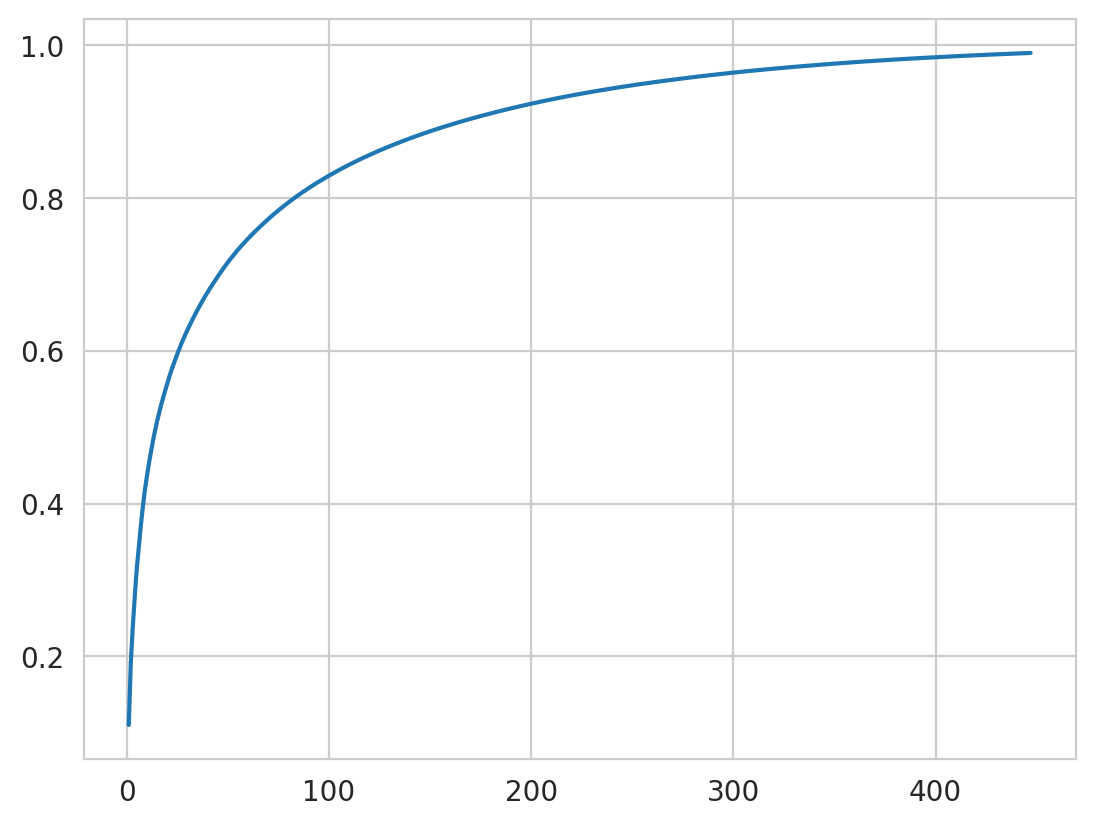

In [43]:
pca = PCA(n_components=0.99, random_state=123)
pca.fit(X_train_binary_poly)
plt.plot(np.arange(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_));

* 2次のインタラクションを含めた2値変数の部分を次元削減した後のものと、元の連続値の部分とを、くっつける


In [44]:
X_train_embedded = np.concatenate([pca.transform(X_train_binary_poly),
                                   X_train[continuous]], 1)

In [45]:
reg = LinearRegression()
reg.fit(X_train_embedded, y_train)

X_valid_binary_poly_embedded = pca.transform(poly.transform(X_valid[binary]))
X_valid_embedded = np.concatenate([X_valid_binary_poly_embedded, X_valid[continuous]], 1)
y_valid_pred = reg.predict(X_valid_embedded)
print(f'RMSE: {root_mean_squared_error(y_valid, y_valid_pred):.4f}')

RMSE: 0.5971


## Ridge回帰
* alphaをチューニングする。

In [46]:
from sklearn.linear_model import Ridge

for alpha in 10. ** np.arange(-5, 6):
  reg = Ridge(alpha=alpha)
  reg.fit(X_train_embedded, y_train)
  y_valid_pred = reg.predict(X_valid_embedded)
  print(f'alpha: {alpha:.1e}; RMSE: {root_mean_squared_error(y_valid, y_valid_pred):.4f}')

alpha: 1.0e-05; RMSE: 0.5971
alpha: 1.0e-04; RMSE: 0.5971
alpha: 1.0e-03; RMSE: 0.5968
alpha: 1.0e-02; RMSE: 0.5942
alpha: 1.0e-01; RMSE: 0.5858
alpha: 1.0e+00; RMSE: 0.5790
alpha: 1.0e+01; RMSE: 0.5750
alpha: 1.0e+02; RMSE: 0.5626
alpha: 1.0e+03; RMSE: 0.6209
alpha: 1.0e+04; RMSE: 0.7876
alpha: 1.0e+05; RMSE: 0.9910


## 交差検証

* ここまで使っていた訓練データと検証データを一つにまとめ直す。

In [47]:
X_train_valid = pd.concat([X_train, X_valid], axis=0)
y_train_valid = pd.concat([y_train, y_valid], axis=0)

* 5-fold交差検証をおこなう

In [48]:
from sklearn.model_selection import KFold

poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)

n_components = 400
pca = PCA(n_components=n_components, random_state=123)

kf = KFold(n_splits=5, shuffle=True, random_state=123)

errors = []
for train_index, valid_index in kf.split(X_train_valid):
  X_train, X_valid = X_train_valid.iloc[train_index], X_train_valid.iloc[valid_index]
  y_train, y_valid = y_train_valid.iloc[train_index], y_train_valid.iloc[valid_index]

  X_train_binary_embedded = pca.fit_transform(poly.fit_transform(X_train[binary]))
  X_train_embedded = np.concatenate([X_train_binary_embedded, X_train[continuous]], 1)

  X_valid_binary_embedded = pca.transform(poly.transform(X_valid[binary]))
  X_valid_embedded = np.concatenate([X_valid_binary_embedded, X_valid[continuous]], 1)

  split_errors = []
  for alpha in 10. ** np.arange(-5, 6):
    reg = Ridge(alpha=alpha)
    reg.fit(X_train_embedded, y_train)
    y_valid_pred = reg.predict(X_valid_embedded)
    error = root_mean_squared_error(y_valid, y_valid_pred)
    print(f'alpha: {alpha:.1e}; RMSE: {error:.4f}', flush=True)
    split_errors.append(error)
  errors.append(split_errors)
  print('-' * 80)

errors = np.array(errors)
print(errors)

alpha: 1.0e-05; RMSE: 0.6202
alpha: 1.0e-04; RMSE: 0.6202
alpha: 1.0e-03; RMSE: 0.6201
alpha: 1.0e-02; RMSE: 0.6195
alpha: 1.0e-01; RMSE: 0.6164
alpha: 1.0e+00; RMSE: 0.6118
alpha: 1.0e+01; RMSE: 0.6138
alpha: 1.0e+02; RMSE: 0.6116
alpha: 1.0e+03; RMSE: 0.6976
alpha: 1.0e+04; RMSE: 0.9248
alpha: 1.0e+05; RMSE: 1.1728
--------------------------------------------------------------------------------
alpha: 1.0e-05; RMSE: 0.5890
alpha: 1.0e-04; RMSE: 0.5889
alpha: 1.0e-03; RMSE: 0.5882
alpha: 1.0e-02; RMSE: 0.5841
alpha: 1.0e-01; RMSE: 0.5767
alpha: 1.0e+00; RMSE: 0.5777
alpha: 1.0e+01; RMSE: 0.5858
alpha: 1.0e+02; RMSE: 0.5856
alpha: 1.0e+03; RMSE: 0.6492
alpha: 1.0e+04; RMSE: 0.8241
alpha: 1.0e+05; RMSE: 1.0479
--------------------------------------------------------------------------------
alpha: 1.0e-05; RMSE: 0.5840
alpha: 1.0e-04; RMSE: 0.5840
alpha: 1.0e-03; RMSE: 0.5838
alpha: 1.0e-02; RMSE: 0.5826
alpha: 1.0e-01; RMSE: 0.5737
alpha: 1.0e+00; RMSE: 0.5549
alpha: 1.0e+01; RMSE: 0.55

* 異なるfoldでRMSEがかなり違う。
 * もっと前から交差検証をしておくべきだったのかも。

In [49]:
for alpha, mean_rmse in zip(10. ** np.arange(-5, 6), errors.mean(0)):
  print(f'alpha: {alpha:.1e}; mean RMSE: {mean_rmse:.4f}')

alpha: 1.0e-05; mean RMSE: 0.6350
alpha: 1.0e-04; mean RMSE: 0.6350
alpha: 1.0e-03; mean RMSE: 0.6350
alpha: 1.0e-02; mean RMSE: 0.6350
alpha: 1.0e-01; mean RMSE: 0.6332
alpha: 1.0e+00; mean RMSE: 0.6260
alpha: 1.0e+01; mean RMSE: 0.6262
alpha: 1.0e+02; mean RMSE: 0.6115
alpha: 1.0e+03; mean RMSE: 0.6674
alpha: 1.0e+04; mean RMSE: 0.8596
alpha: 1.0e+05; mean RMSE: 1.1018


## 一番良かった手法で最終評価

* ここまででは、以下の設定にたどり着いた。
 * 2値変数の2次のインタラクションを使う。
 * 2値の部分をPCAで400次元に落とす。
 * Ridge回帰を`alpha=10.0`で適用
* そこで、この手法を採用して、テストデータで最終評価する。


In [50]:
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)

n_components = 400
pca = PCA(n_components=n_components, random_state=123)

X_train_valid_binary_poly_embedded = pca.fit_transform(poly.fit_transform(X_train_valid[binary]))
X_train_valid_embedded = np.concatenate([X_train_valid_binary_poly_embedded, X_train_valid[continuous]], 1)

reg = Ridge(alpha=10.0)
reg.fit(X_train_valid_embedded, y_train_valid)

X_test_binary_poly_embedded = pca.transform(poly.transform(X_test[binary]))
X_test_embedded = np.concatenate([X_test_binary_poly_embedded, X_test[continuous]], 1)
y_test_pred = reg.predict(X_test_embedded)
print(f'RMSE: {root_mean_squared_error(y_test, y_test_pred):.4f}')

RMSE: 0.6534


# 課題
* solubilityデータセットの、上で作った検証データに対して、できるだけ予測性能の良いモデルを見つけよう
  * Ridge回帰やLassoを使ってもいいです。
  * 特徴量はどのように加工してもいいです。（上では2値変数にPCAを使った。）
* 検証データを使って見つけた最も良いモデルを、最後に一回、テストデータで評価してみよう

In [70]:
from sklearn.pipeline      import Pipeline
from sklearn.compose       import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model  import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics       import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

In [65]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [55]:
cont_cols = [c for c in X.columns if c[:3] in ["Num","Hyd","Mol","Sur"]]

bin_cols  = [c for c in X.columns if c.startswith("FP")]

In [71]:
param_dist = {
  "pre__bin__pca__n_components": [50, 100, 200, 400],
  "model": [Ridge(), Lasso(max_iter=10000)],
  "model__alpha": np.logspace(-5, 5, 11)
}


rand_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=40,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=2,
    random_state=42
)


rand_search.fit(X_train, y_train)


print("■ Best params (rand):", rand_search.best_params_)
print("■ Valid CV RMSE:", -rand_search.best_score_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
■ Best params (rand): {'pre__bin__pca__n_components': 200, 'model__alpha': np.float64(1.0), 'model': Ridge()}
■ Valid CV RMSE: 0.6414544073064565


In [76]:
nicebest_model = rand_search.best_estimator_

y_val_pred = nicebest_model.predict(X_val)
mse_val   = mean_squared_error(y_val, y_val_pred)
rmse_val  = np.sqrt(mse_val)
print("■ Hold‐out RMSE:", rmse_val)

X_tv       = pd.concat([X_train, X_val], axis=0)
y_tv       = pd.concat([y_train, y_val], axis=0)
nicebest_model.fit(X_tv, y_tv)

y_test_pred = nicebest_model.predict(X_test)
mse_test    = mean_squared_error(y_test, y_test_pred)
rmse_test   = np.sqrt(mse_test)
print("■ Test RMSE:   ", rmse_test)


■ Hold‐out RMSE: 0.5697882859588052
■ Test RMSE:    0.6980238209499756
